In [1]:
# Google Driveをcolabにマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 各種ライブラリインポート
%matplotlib inline
import urllib
import pickle
import cv2
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models

import matplotlib.pyplot as plt
import seaborn as sns
# colabをダークモードにしていると、グラフ表示したときに目盛が見えなくなってしまうことに対する対処
sns.set_style("white") 

drive_dir = "drive/My Drive/Colab Notebooks/grad-cam/"

In [ ]:
# ImageNetのラベル情報をダウンロード
labels = pickle.load(urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl') )
labels

In [ ]:
for key, val in labels.items():
    if "cat" in val:
        print(key, val)

30 bullfrog, Rana catesbeiana
89 sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita
143 oystercatcher, oyster catcher
281 tabby, tabby cat
282 tiger cat
283 Persian cat
284 Siamese cat, Siamese
285 Egyptian cat
286 cougar, puma, catamount, mountain lion, painter, panther, Felis concolor
287 lynx, catamount
358 polecat, fitch, foulmart, foumart, Mustela putorius
361 skunk, polecat, wood pussy
383 Madagascar cat, ring-tailed lemur, Lemur catta
387 lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens
484 catamaran
688 oscilloscope, scope, cathode-ray oscilloscope, CRO


In [4]:
# 学習済みモデルとしてVGG19を読み込む
model = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


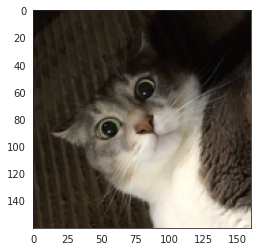

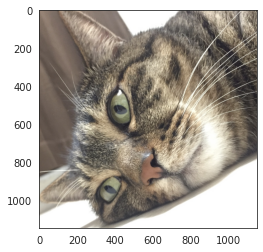

In [5]:
# 検証する画像を読み込んで表示する
test_image1 = Image.open(drive_dir + "neko.png")
test_image2 = Image.open(drive_dir + "neko2.JPG")

plt.imshow(test_image1)
plt.show()

plt.imshow(test_image2)
plt.show()

In [6]:
# 検証画像をVGG19のネットワークに通せるように変換する処理

# 画像の縦横を224x224にしてtensor型に変換
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_image1_tensor = transform(test_image1)
test_image2_tensor = transform(test_image2)
print(test_image1_tensor.size()) # 色情報（チャネル）x高さx幅

# ネットワークに通すには(batch_size, channel, height, width)じゃないといけないので、batch_size=1を挿入
test_image1_tensor = test_image1_tensor.unsqueeze(0)
test_image2_tensor = test_image2_tensor.unsqueeze(0)
print(test_image2_tensor.size())

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [ ]:
# 検証画像をVGG19で予測させてみる
# モデルを検証モードに変更してから画像をネットワークに流す
model = model.eval()
with torch.no_grad():
    predict1_index = model(test_image1_tensor).max(1)[1]
    predict2_index = model(test_image2_tensor).max(1)[1]
    print(int(predict1_index))
    print('検証画像1の予測結果', labels[int(predict1_index)])
    print('検証画像2の予測結果', labels[int(predict2_index)])

332
検証画像1の予測結果 Angora, Angora rabbit
検証画像2の予測結果 Siamese cat, Siamese


In [ ]:
print(model)

# 実装方法その1
modelからGrad-CAMの計算に必要な中間層（特徴マップを計算する畳み込みの部分）を初めから切り離して計算する方法
- 参考  
https://deepblue-ts.co.jp/%e7%94%bb%e5%83%8f%e5%87%a6%e7%90%86/%e3%80%90pytorch%e3%80%91gradcam%e3%82%92%e7%94%a8%e3%81%84%e3%81%9fcnnvgg16%e3%81%ae%e5%8f%af%e8%a6%96%e5%8c%96/

In [ ]:
# Grad-CAMを計算するときは特徴マップが必要なので、modelから特徴マップを計算するネットワークのところを取り出す
features = model.features.eval()
avgpool = model.avgpool.eval()
classifier = model.classifier.eval()

In [ ]:
# 特徴マップを抽出する
feature = features(test_image2_tensor)
print('特徴マップサイズ', feature.size())

# xxxxx
feature = feature.clone().detach().requires_grad_(True)

# 特徴マップをVGG19の残りの全結合層に通して、予測結果を得る
pooled = avgpool(feature)
y_pred = classifier(pooled.view(-1,512*7*7))
pred_index = torch.argmax(y_pred)

# 予測結果に対して誤差逆伝播
y_pred[0][pred_index].backward()

特徴マップサイズ torch.Size([1, 512, 7, 7])


In [ ]:
# 特徴マップの勾配(feature.grad)のGlobal Average Poolingを計算する
# つまり512枚の各特徴マップの要素の平均値を算出する（512次元のベクトルになる）

# まずは7x7のそれぞれの特徴マップを１本のベクトルに変換
feature_vec = feature.grad.view(512, 7*7) # feature_vec.size() = (512, 49)

# 512本のそれぞれのベクトルの要素の平均を取る
# 論文のαが計算される
alpha = torch.mean(feature_vec, axis=1) # alpha.size() = (512)

# batch_sizeの次元を削除
# (1x512x7x7) -> (512x7x7)
feature = feature.squeeze(0)

L = F.relu(torch.sum(feature*alpha.view(-1,1,1),0))#.cpu().detach().numpy()
L = L.detach().numpy()
# L.size() = (7x7)

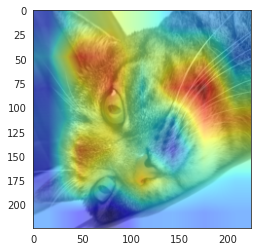

In [ ]:
# 0-1で正規化
L_min = np.min(L)
L_max = np.max(L - L_min)
L = (L - L_min)/L_max

# 元画像と同じサイズにリサイズする
L = cv2.resize(L, (224, 224))

# heat map に変換
def toHeatmap(x):
    x = (x*255).reshape(-1)
    cm = plt.get_cmap('jet')
    x = np.array([cm(int(np.round(xi)))[:3] for xi in x])
    return x.reshape(224,224,3)

img2 = toHeatmap(L)

img1 = test_image2_tensor.squeeze(0).permute(1,2,0)

alpha = 0.5
grad_cam_image = img1*alpha + img2*(1-alpha)

plt.imshow(grad_cam_image)

# 実装方法その2
register_forward_hookとregister_backward_hookを使って、順伝搬時と逆伝搬時に計算された特徴マップ及び特徴マップの勾配を抽出できるようにする
- 参考  
https://tech.jxpress.net/entry/2018/12/12/130057

In [ ]:
# moduleのforward関数が呼ばれるときに一緒に実行したい内容を記載する
# module: 登録先のネットワーク
# inputs: moduleのforward関数のインプットとなったデータ
# outputs: moduleのforward関数のアウトプット
def forward_hook(module, inputs, outputs):
    global feature
    # 複数のinputsに対応できるようにinputsはtupleでラップされるようです
    # 今回はinputsは1つだけなので、[0]を指定する
    # hook関数の登録先であるmoduleは今回は特徴マップを計算する層（model.features）を想定しているので
    # model.featuresの計算結果であるoutputsをそのまま取得できるようにすればよし
    feature = outputs[0] # feature.size() = (1x512x7x7)

# moduleのbackward関数が呼ばれるときに一緒に実行したい内容を記載する
# module: 登録先のネットワーク
# grad_inputs: moduleのbackward関数のインプットとなったデータ
# grad_outputs: moduleのfbackward関数のアウトプット
def backward_hook(module, grad_inputs, grad_outputs):
    global feature_grad
    # hook関数の登録先であるmoduleはforward_hookと同様にmodel.featuresを想定しており、
    # 特徴マップの勾配がほしいので、model.featuresの勾配結果に相当するgrad_outputsをそのまま取得すればよし
    feature_grad = grad_outputs[0] # feature_grad.size() = (1x512x7x7)

# 畳み込み層にhook関数を登録する
# これによりVGG19にデータが流れる時、順伝搬の畳み込みの処理のところで上記のforward_hookが呼び出され（つまりグローバル変数featureに特徴マップが格納され）
# 逆伝搬時にグローバル変数feature_gradに特徴マップの勾配が格納されることになる
model.features.register_forward_hook(forward_hook)
model.features.register_backward_hook(backward_hook)

# VGG19のモデルにそのまま検証する画像を流して予測結果を得る
# このタイミングで上記のforward_hookが裏で実行されてます
y_pred = model(test_image1_tensor)
print("アンゴララビットである確率", F.softmax(y_pred)[0][332].item())
print("虎猫である確率", F.softmax(y_pred)[0][281].item())
print("シャム猫である確率", F.softmax(y_pred)[0][284].item())
# pred_index = torch.argmax(y_pred)
# pred_index = torch.tensor(332)
# print(y_pred)

# 予測結果に対して誤差逆伝播
# このタイミングで上記のbackward_hookが裏で実行されてます
y_pred[0][pred_index].backward()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


アンゴララビットである確率 0.5156328082084656
虎猫である確率 0.0016278631519526243
シャム猫である確率 0.007759877946227789


In [ ]:
# 以降の計算は実装方法その1と同様でOK

# 特徴マップの勾配(feature.grad)のGlobal Average Poolingを計算する
# つまり512枚の各特徴マップの要素の平均値を算出する（512次元のベクトルになる）

# まずは7x7のそれぞれの特徴マップを１本のベクトルに変換
feature_vec = feature_grad.view(512, 7*7) # feature_vec.size() = (512, 49)

# 512本のそれぞれのベクトルの要素の平均を取る
# 論文のαが計算される
alpha = torch.mean(feature_vec, axis=1) # alpha.size() = (512)

# batch_sizeの次元を削除
# (1x512x7x7) -> (512x7x7)
feature = feature.squeeze(0)

L = F.relu(torch.sum(feature*alpha.view(-1,1,1),0))#.cpu().detach().numpy()
L = L.detach().numpy()

# L.size() = (7x7)

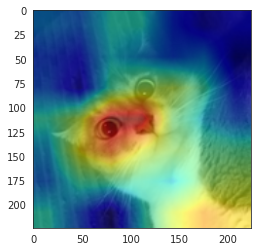

In [ ]:
# 0-1で正規化
L_min = np.min(L)
L_max = np.max(L - L_min)
L = (L - L_min)/L_max

# 元画像と同じサイズにリサイズする
L = cv2.resize(L, (224, 224))

# heat map に変換
def toHeatmap(x):
    x = (x*255).reshape(-1)
    cm = plt.get_cmap('jet')
    x = np.array([cm(int(np.round(xi)))[:3] for xi in x])
    return x.reshape(224,224,3)

img2 = toHeatmap(L)

img1 = test_image1_tensor.squeeze(0).permute(1,2,0)

alpha = 0.5
grad_cam_image = img1*alpha + img2*(1-alpha)

plt.imshow(grad_cam_image)

# Adversarial Attackを試してみる＆Grad-CAMで異変に気付けるか試してみる
- References  
https://elix-tech.github.io/ja/2017/10/15/adversarial.html  
https://qiita.com/ohnabe/items/dc915c06ef37a2d30799  
https://qiita.com/deaikei/items/ecbf2e796e771bf7113f

### パンダ画像はこちらから拝借しました
https://blue-wind.net/cat/%E5%8B%95%E7%89%A9/%E3%83%91%E3%83%B3%E3%83%80  
https://publicdomainq.net/giant-panda-animal-0012293/


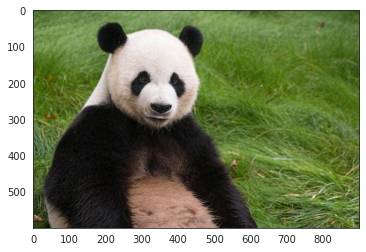

In [36]:
# model = models.vgg19(pretrained=True)

panda_image = Image.open(drive_dir + "panda4.jpg")
plt.imshow(panda_image)
plt.show()

In [37]:
# 前処理
panda_tensor = transform(panda_image)
print(panda_tensor.size())
panda_tensor = panda_tensor.unsqueeze(0)
# original_panda_tensor = panda_tensor.clone().detach()


torch.Size([3, 224, 224])


In [40]:
panda_tensor = panda_tensor.requires_grad_(True)
y_pred = model(panda_tensor)
criterion = nn.CrossEntropyLoss()
loss = criterion(y_pred, torch.tensor([388]))
loss.backward()
epsilon = 0.007
eta = epsilon*np.sign(panda_tensor.grad)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


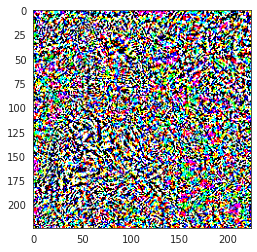

In [41]:
plt.imshow(np.sign(panda_tensor.grad).squeeze(0).permute(1,2,0).detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


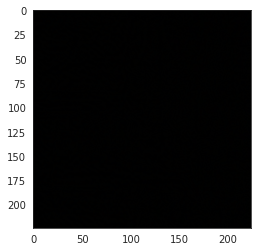

In [30]:
plt.imshow(eta.squeeze(0).permute(1,2,0).detach().numpy())

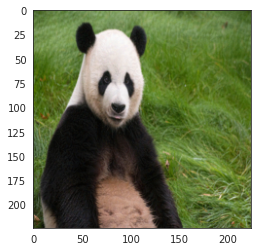

In [42]:
panda_tensor = panda_tensor + eta
plt.imshow(panda_tensor.squeeze(0).permute(1,2,0).detach().numpy())

回答 296 ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus
確率 0.25158318877220154


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


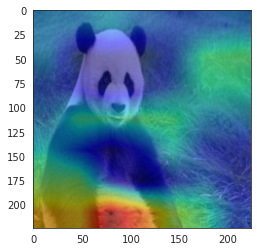

In [43]:
def forward_hook(module, inputs, outputs):
    global feature
    feature = outputs[0] 

def backward_hook(module, grad_inputs, grad_outputs):
    global feature_grad
    feature_grad = grad_outputs[0] 

model = model.eval()
model.features.register_forward_hook(forward_hook)
model.features.register_backward_hook(backward_hook)

y_pred = model(panda_tensor)
pred_index = y_pred.argmax().item()
print("回答", pred_index ,labels[pred_index])
print("確率", F.softmax(y_pred)[0][pred_index].item())
y_pred[0][pred_index].backward()

feature_vec = feature_grad.view(512, 7*7) 
alpha = torch.mean(feature_vec, axis=1) 
feature = feature.squeeze(0)

L = F.relu(torch.sum(feature*alpha.view(-1,1,1),0))
L = L.detach().numpy()

L_min = np.min(L)
L_max = np.max(L - L_min)
L = (L - L_min)/L_max

L = cv2.resize(L, (224, 224))

# heat map に変換
def toHeatmap(x):
    x = (x*255).reshape(-1)
    cm = plt.get_cmap('jet')
    x = np.array([cm(int(np.round(xi)))[:3] for xi in x])
    return x.reshape(224,224,3)

img2 = toHeatmap(L)

img1 = panda_tensor.squeeze(0).permute(1,2,0).detach().numpy()

alpha = 0.5
grad_cam_image = img1*alpha + img2*(1-alpha)

plt.imshow(grad_cam_image)

回答 388 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
確率 0.9090976715087891


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


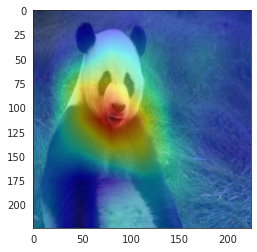

In [38]:
def forward_hook(module, inputs, outputs):
    global feature
    feature = outputs[0] 

def backward_hook(module, grad_inputs, grad_outputs):
    global feature_grad
    feature_grad = grad_outputs[0] 

model = model.eval()
model.features.register_forward_hook(forward_hook)
model.features.register_backward_hook(backward_hook)

y_pred = model(panda_tensor)
pred_index = y_pred.argmax().item()
print("回答", pred_index ,labels[pred_index])
print("確率", F.softmax(y_pred)[0][pred_index].item())
y_pred[0][pred_index].backward()

feature_vec = feature_grad.view(512, 7*7) 
alpha = torch.mean(feature_vec, axis=1) 
feature = feature.squeeze(0)

L = F.relu(torch.sum(feature*alpha.view(-1,1,1),0))
L = L.detach().numpy()

L_min = np.min(L)
L_max = np.max(L - L_min)
L = (L - L_min)/L_max

L = cv2.resize(L, (224, 224))

# heat map に変換
def toHeatmap(x):
    x = (x*255).reshape(-1)
    cm = plt.get_cmap('jet')
    x = np.array([cm(int(np.round(xi)))[:3] for xi in x])
    return x.reshape(224,224,3)

img2 = toHeatmap(L)

img1 = panda_tensor.squeeze(0).permute(1,2,0)

alpha = 0.5
grad_cam_image = img1*alpha + img2*(1-alpha)

plt.imshow(grad_cam_image)

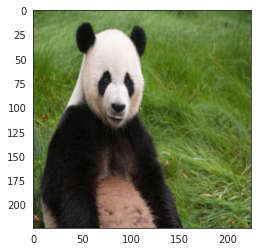

In [39]:
plt.imshow(panda_tensor.squeeze(0).permute(1,2,0).detach().numpy())